In [1]:
# import library
from library import *

# filter the warnings for clarity
import warnings
warnings.filterwarnings("ignore")

## Jupyter Notebook - ECL Demo 💸📜📈

### Introduction

In today's data-driven world, financial analysis requires integrating diverse sources of information, including numerical and textual data. The ECL dataset contains the multimodal data from the corporate 10K reports that public companies in the United States file with the Securities and Exchange Commission (SEC). Throughout this notebook, we will guide you in the process of loading, preprocessing, and analyzing the dataset. We will demonstrate how to extract meaningful information from textual data, perform analysis on the numerical features, and leverage visualization to enhance our understanding of the data.

**Paper:**

```Henri Arno, Klaas Mulier, Joke Baeck, and Thomas Demeester. 2023. From Numbers to Words: Multi-Modal Bankruptcy Prediction Using the ECL Dataset. In Proceedings of the Sixth Workshop on Financial Technology and Natural Language Processing (FinNLP), Bali, Indonesia. Association for Computational Linguistics.```

### Prerequisites

The numerical financial variables are derived from CompuStat, a Standard&Poor's database, which is only accessible via a paid subscription. **Hence, access to CompuStat is needed**, via (1) the WRDS Python API or (2) a local copy of the data. **If you are only interested in the textual data, access to CompuStat is not needed, and you do not need a paid subscription.**

### The structure of the ECL Dataset

The ECL dataset is a unique compilation derived from three data sources: the EDGAR-corpus, CompuStat, and the LoPucki Bankruptcy Research Database (BRD). (1) The EDGAR-corpus provides the textual data from the 10K filings, (2) CompuStat serves as our data source for the numerical financial data from the 10Ks, while (3) the LoPucki BRD supplies labels for the bankruptcy prediction task. 

The ECL dataset is as a single .csv file, where each row corresponds to a 10K filing. Such a filing is characterised by a company identifier (the *cik*, *gvkey*, or *company name*) and a date (the fiscal year end, corresponding to the *period_of_report* variable). When designing the dataset, we decided not to store the multimodal data in the ECL .csv file, but we opted to store pointers from a 10K record in ECL to the relevant records in the source datasets. This structure (1) allows users to extract the necessary variables easily with a limited computational burden and (2) ensures that we do not violate the terms of use of the proprietary CompuStat data.

- A 10K record in our dataset maps to a textual record in the EDGAR-corpus via the variable *filename*. This variable represents the relative path to the JSON file in the corpus, which contains the textual data from the 10K filing.
- A 10K record in our dataset maps to a record in the CompuStat dataset via the *gvkey* and *datadate* variables. These keys uniquely identify a record in CompuStat which contains the numerical financial data from the 10K filing.
- All the relevant variables for the bankruptcy prediction task are included in our dataset and do not need to be extracted from the LoPucki BRD.

**The dataset design is schematically shown in the figure below:**

```For access to the EDGAR-corpus and the ECL .csv file, see the README of this repository.```

<div>
<img src="images/schema.png" width="600" align="center"/>
</div>

In [2]:
# Read in the dataset.
dataset = pd.read_csv('ECL.csv', index_col=0)

In [3]:
# let's inspect some records!
dataset.sample(5)

,cik,company,period_of_report,gvkey,datadate,filename,can_label,qualified,label,bankruptcy_prediction_split,bankruptcy_date_1,bankruptcy_date_2,bankruptcy_date_3,filing_date
98886,1571498.0,"EPIZYME, INC.",2016-12-31,17808.0,31/12/2016,/2016/1571498_10K_2016_0001193125-17-079460.json,True,No,False,out-of-scope,NaN,NaN,NaN,2017-03-13
180333,1057007.0,HUDSON RIVER BANCORP INC,2000-03-31,112186.0,31/03/2000,/2000/1057007_10K_2000_0000914317-00-000452.json,True,Yes,False,train,NaN,NaN,NaN,2000-06-20
158652,1003950.0,PERFORMANCE TECHNOLOGIES INC \DE\,2007-12-31,61903.0,31/12/2007,/2007/1003950_10K_2007_0001003950-08-000020.json,True,No,False,out-of-scope,NaN,NaN,NaN,2008-03-17
181176,1091566.0,WORLDTEQ GROUP INTERNATIONAL INC,2002-12-31,113422.0,31/12/2002,/2002/1091566_10KSB_2002_0001015402-03-001661....,True,No,False,out-of-scope,NaN,NaN,NaN,2003-05-07
31083,7536.0,ARROW ELECTRONICS INC,2021-12-31,1773.0,31/12/2021,/2021/7536_10K_2021_0001859644-22-000008.json,True,out-of-period,False,out-of-scope,NaN,NaN,NaN,2022-02-11


### Option 1: Extracting numerical financial data from CompuStat using the WRDS Python API

We will now show how the WRDS Python API can be used to extract numerical financial data from CompuStat, which is subsequently added to the ECL dataset. When using the API for the first time, you will need to login using your WRDS username and password. For a thorough explanation on how to install and use the API, see the documentation: https://wrds-www.wharton.upenn.edu/pages/support/programming-wrds/programming-python/querying-wrds-data-python/

```If you do not have access to a WRDS account but you do have a local copy of CompuStat, jump to the next section!```

In [ ]:
# Login using WRDS credentials.
username = ''
db = wrds.Connection(wrds_username=username)

CompuStat has many variables and typically, only a subset is required for the analysis at hand. Therefore, **you can specify which variables to extract, by listing them in the cell below!** For a complete list of all the variables that are available in CompuStat, we refer to the documentation on the WRDS website.

In [ ]:
# The desired CompuStat variables (list them in a string and seperate with ',')
variables = 'ch, dt, act'

The WRDS python API is organised in libraries containing various data tables. We will be using the *comp_na_annual_all* library (i.e., CompuStat North America Annual) and the *funda* table (i.e., Fundamentals data) since we are interested in numerical financial data from 10K filings.

We collect the data using the function get_CompuStat_WRDS(), which performs the following steps:
- Set the CompuStat screening variables to the appropriate values. These variables (*datafmt, indfmt, consol* and *popsrc*) ensure that each CompuStat record is uniquely identified by a *gvkey-datadate* pair.
- Fetch the specified CompuStat variables from the WRDS server with a correct SQL query.
- Merge the collected CompuStat data with the ECL dataset on *gvkey-datadata*.

In [ ]:
# Add the CompuStat variables to the ECL dataset.
dataset = get_CompuStat_WRDS(variables, dataset, db)

# let's inspect some records!
dataset.sample(5)[['cik', 'company', 'period_of_report', 'ch', 'dt', 'act']]

### Option 2: Extracting numerical financial data from a local copy of CompuStat

If you do not have access to CompuStat via the WRDS data platform, but through another data vendor, you can link the ECL records with CompuStat records via a local copy of the CompuStat database. All that you need to specify is the path to this copy, stored as a .csv file and the *get_CompuStat_local()* function will take care of the rest:

- Read in the local copy of CompuStat.
- Filter the records based on the CompuStat screening variables. These variables (¨*datafmt, indfmt, consol* and *popsrc*) ensure that each CompuStat record is uniquely identified by a *gvkey-datadate* pair.
- Merge the collected CompuStat data with the ECL dataset on *gvkey-datadata*.

In [4]:
# Path to the CompuStat data.
path = './data/CompuStat/data.csv'

# Add the CompuStat variables to the dataset
dataset = get_CompuStat_local(path, dataset, update=False)

# let's inspect some records!
dataset.sample(5)[['cik', 'company', 'period_of_report', 'ch', 'dt', 'act']]

Dropped 115373 rows from CompuStat based on screening variables
0 records in the dataset do not have an accompanying CompuStat record.


,cik,company,period_of_report,ch,dt,act
138458,1022329.0,IMPSAT CORP,1998-12-31,90.021,400.430,159.099
151342,899460.0,MANNKIND CORP,2016-12-31,22.895,77.156,77.488
101667,1817229.0,VOR BIOPHARMA INC.,2022-12-31,57.706,38.912,236.950
144946,1042773.0,RELIANT ENERGY RESOURCES CORP,1999-12-31,81.347,NaN,1810.126
123426,1046327.0,REALNETWORKS INC,2008-12-31,232.968,0.000,479.560


### Extract textual data from the EDGAR-corpus 

As explained above, the records in the ECL dataset are mapped to records in the EDGAR-corpus via the *filename* variable. We simply need to read in the JSON file stored at the location given by this variable to access the textual data. Each JSON file is organised based on the different items in a 10K report. Let's inspect the textual data for the most recent Google 10K filing!

In [5]:
# Location to the corpus.
corpus_path = './data'

# Extract the filename for the latest Tesla record.
file = dataset.loc[dataset['cik'] == 1318605, 'filename'].iloc[-1]

# Read in the file.
with open(corpus_path + file) as fp:
    text = json.load(fp)

In [6]:
# Now we can access the text in a dictionary!
print(text['item_7'][802:1700] + '...')

Our mission is to accelerate the world’s transition to sustainable energy. We design, develop, manufacture, lease and sell high-performance fully electric vehicles, solar energy generation systems and energy storage products. We also offer maintenance, installation, operation, financial and other services related to our products. Additionally, we are increasingly focused on products and services based on artificial intelligence, robotics and automation.
In 2022, we produced 1,369,611 consumer vehicles and delivered 1,313,851 consumer vehicles, despite ongoing supply chain and logistics challenges and factory shutdowns. We are currently focused on increasing vehicle production, capacity and delivery capabilities, improving and developing battery technologies, improving our FSD capabilities, increasing the affordability and efficiency of our vehicles, bringing new products to market and ...


### Example Analysis

Let's start off by plotting how the average total current assets and the average cash evolves over time. 

Notice that these are *current* values, which are not corrected for inflation! This is just a very simple example but Python has a lot to offer when it comes to visualisation of data, for more details, we refer to the documentation of Matplotlib: https://matplotlib.org/.

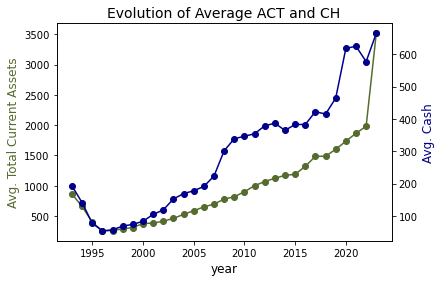

In [7]:
# Add the fiscal year as a variable.
dataset['year'] = pd.to_datetime(dataset['period_of_report']).dt.year
# Create figure and axis object.
fig,ax = plt.subplots()
# Make plot.
ax.plot(dataset[['year', 'act']].groupby('year').mean(), color="darkolivegreen", marker="o")
ax.set_xlabel("year", fontsize = 12)
ax.set_ylabel("Avg. Total Current Assets", color="darkolivegreen", fontsize=12)
ax.set_title('Evolution of Average ACT and CH', fontsize=14)

# Twin axis object.
ax2=ax.twinx()
# Make plot.
ax2.plot(dataset[['year', 'ch']].groupby('year').mean(),color="darkblue",marker="o")
ax2.set_ylabel("Avg. Cash",color="darkblue",fontsize=12)
plt.show()

Let's turn to an example involving text! One interesting section of a 10K filing is **Item 7: Management Discussion and Analysis.** *“... it gives the company’s perspective on the business results of the past financial year. This section, known as the MD&A for short, allows company management to tell its story in its own words.”*

The variable *label* of a 10K record in the dataset, is a binary indicator that is True if the company filed for bankruptcy in the year after filing the 10K. We can, for instance, generate a wordcloud and inspect some key words used by management in the reports filed one year prior to bankruptcy. This initial analysis can reveal some interesting terms that might be usefull to discriminate between healthy firms and firms on the verge of bankruptcy.

In [8]:
# First, we read in the data and store item_7 of the reports...
text = ""
for file in dataset.loc[dataset['label'] == True, 'filename']:
    
    with open(corpus_path + file) as fp:
        text = text + (json.load(fp)['item_7'])

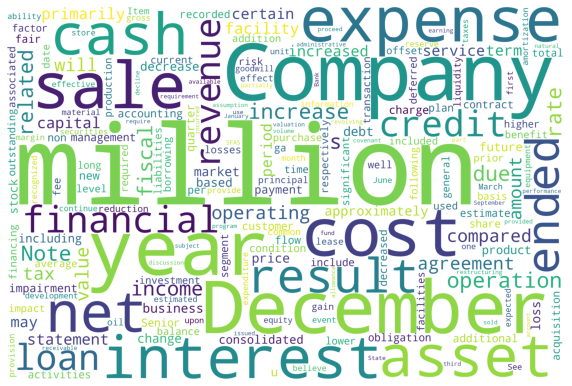

In [9]:
# ...then we geneate the wordcloud and show it in the notebook
wordcloud = WordCloud(width = 3000, height = 2000, random_state=4, background_color='white', collocations=False, stopwords = STOPWORDS).generate(text)
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud) 
plt.axis("off")
plt.show()
